# Automatic Seismic to Well Tie

#### Import packages

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
import yaml

from wtie import grid, autotie, viz
from wtie.utils.datasets import tutorial

from pprint import pprint

import matplotlib.pyplot as plt

# uncomment if your browser supports it
#%matplotlib notebook 

### Import data


In this tutorial we work on data from the Well *Torosa1* of the open [Poseidon](https://terranubis.com/datainfo/NW-Shelf-Australia-Poseidon-3D) dataset. Data is saved in the folder **data/tutorial**.

In [2]:
# data path
folder = Path('../data/tutorial')
assert folder.exists()

inputs = tutorial.load_poseidon_data(folder, well='torosa1')

### Load pretrained network to extract the wavelet

In [3]:
# neural network's weights
model_state_dict = folder / 'trained_net_state_dict.pt'
assert model_state_dict.is_file()

# network training paramters
with open(folder / 'network_parameters.yaml', 'r') as yaml_file:
    training_parameters = yaml.load(yaml_file, Loader=yaml.Loader)
    
wavelet_extractor = tutorial.load_wavelet_extractor(training_parameters, model_state_dict)

Loading network parameters from ..\data\tutorial\trained_net_state_dict.pt


### Load synthetic modeling tool

In [4]:
modeler = tutorial.get_modeling_tool()

### Parameters for the search

In [5]:
print(autotie.tie_v1.__doc__)


    Utility to perform automatic (prestack) seismic to well tie. This version 1
    serves as a base recipe. Feel free to implement your own recipe using the
    various tools of the package.

    Parameters
    ----------
    inputs : _tie.InputSet
        Necessary inputs for the well tie.
    wavelet_extractor : wtie.learning.model.BaseEvaluator
        Object to extract a wavelet using the provided neural network.
    modeler : wtie.modeling.modeling.ModelingCallable
        Synthetic modeling tool.
    wavelet_scaling_params : dict
        Parameters for the search of the optimal absolute wavelet sacle.
        3 parameters: 'wavelet_min_scale' and 'wavelet_max_scale' are the search
        bounds. 'num_iters' (optional) is the total number of iterations for the
        search.
    search_space : dict, optional
        Bounds of the search space. See `get_default_search_space_v1`.
    search_params : dict, optional
        Dict with 3 parameters for the Bayesian search. 'num_iter

#### Define the tie parameters search space (optional)

So far, supported parameters correspond to the log filtering and depth to time table bulk shift. See the `tie.get_default_search_space_v1` docstring.

In [6]:
print(autotie.get_default_search_space_v1.__doc__)


    Search space of version 1 is composed of 4 parameters:
        - "logs_median_size" : size (in number of samples) of the median filter window.
        - "logs_median_threshold" : threshold value with respect to the logs standard deviation.
        - "logs_std" : standard deviation of the gaussian smoothing filter.
        - "table_t_shift" : bulk shift in seconds of the depth-time relation table.

    Parameters are defined following the [Ax](https://github.com/facebook/Ax)
    documentation.


In [7]:

# Logs processing
median_length_choice = dict(name="logs_median_size", type="choice",
                  values=[i for i in range(11,63,2)], value_type="int")

median_th_choice = dict(name="logs_median_threshold", type="range",
                  bounds=[0.1, 5.5], value_type="float")

std_choice = dict(name="logs_std", type="range",
                  bounds=[0.5, 5.5], value_type="float")


# bulk shift in seconds
table_t_shift_choice = dict(name="table_t_shift", type="range",
                  bounds=[-0.012, 0.012], value_type="float")


search_space = [median_length_choice,
                median_th_choice,
                std_choice,
                table_t_shift_choice
                ]

#### Bayesian search parameters (optional)

In [8]:
search_params = dict(num_iters=80, similarity_std=0.02)

#### Wavelet absolute amplitude search params

In [9]:
wavelet_scaling_params = dict(wavelet_min_scale=50000, wavelet_max_scale=500000, num_iters=60)

### Optimization

In [10]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


outputs = autotie.tie_v1(inputs,
                         wavelet_extractor,
                         modeler,
                         wavelet_scaling_params,
                         search_params=search_params,
                         search_space=search_space,
                         stretch_and_squeeze_params=None) 

stage 0
Tensor Details:
- Size: torch.Size([32])
- Device: cpu
- Type: <class 'torch.nn.parameter.Parameter'>

Tensor Details:
- Size: torch.Size([32])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([64])
- Device: cpu
- Type: <class 'torch.nn.parameter.Parameter'>

Tensor Details:
- Size: torch.Size([64])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([128])
- Device: cpu
- Type: <class 'torch.nn.parameter.Parameter'>

Tensor Details:
- Size: torch.Size([128])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([32])
- Device: cpu
- Type: <class 'torch.nn.parameter.Parameter'>

Tensor Details:
- Size: torch.Size([32])
- Device: cpu
- Type:

  2%|▎         | 2/80 [00:00<00:06, 12.74it/s]

upper
[3565.63731806 3624.88015157 3697.31281943 3494.56534565 3401.45298788
 3502.31467729 3568.4334698  3580.32594083 3543.5053722  3499.74388463
 3476.18106648 3468.42176273 3427.56702702 3463.10362379 3597.92583572
 4015.1838379  4462.45355602 4498.10454877 4664.92154603 4806.64898381
 4602.42538222 4323.14850292 4102.04635985 4093.10592362 4100.25455787
 4061.48927106 3949.59647878 3835.46286305 3937.74767572 3997.26310993
 3863.81076123 3859.71134758 4038.22285423 4118.62226009 4162.3476681
 4066.52282661 3827.98874404 3809.88907005 3799.16562372 3807.86857455
 3825.8858937  3594.39619849 3564.44605042 3667.74849167 3506.26182851
 3449.63930958 3471.85443098 3291.57659169 3208.27262558 3249.47763517
 3228.60522875 3171.42995591 3186.53141581 3392.81826103 3542.69325383
 3575.23934471 3639.69458827 3653.53261414 3672.63018834 3672.86382786
 3683.87197272 3705.22325678 3643.69052464 3639.18455912 3609.94201667
 3535.19193378 3552.06105638 3575.5796966  3550.65368774 3559.18793155
 

  5%|▌         | 4/80 [00:00<00:05, 13.55it/s]

upper
[3551.906462   3614.82769875 3743.74334839 3478.28879448 3378.75050886
 3513.89156348 3571.41742873 3589.46473022 3543.29830171 3495.58744421
 3477.14173522 3469.11314518 3424.49025561 3446.85456234 3560.66197151
 4013.28165095 4506.0054427  4588.70354931 4779.25496348 4827.87552883
 4608.08543981 4321.98481511 4073.63479995 4103.01721481 4096.20039132
 4073.46230977 3953.06750034 3806.88224836 3942.85788831 4024.56474434
 3847.8438065  3831.63640592 4060.4092213  4115.42006514 4173.95282743
 4091.87225022 3788.1282409  3821.11486888 3796.2963313  3796.25119775
 3895.91741881 3573.67681715 3533.61659554 3724.5394706  3480.97054499
 3430.56307767 3520.95418917 3265.34497856 3188.67324367 3264.7916306
 3233.81138822 3166.99830316 3140.90176785 3410.2666172  3568.16274524
 3558.111516   3655.62785141 3646.86459088 3677.68968423 3672.62306557
 3676.81436386 3724.66082034 3628.2934681  3645.26663174 3619.68750522
 3517.57697024 3553.66885031 3584.2117314  3545.98805391 3549.42773788
 

 10%|█         | 8/80 [00:00<00:05, 13.03it/s]

upper
[3547.29986217 3587.61189944 3908.45504206 3631.70431564 3369.07840436
 3510.12264954 3582.13231931 3582.22259594 3547.56635488 3494.82464796
 3470.03561073 3481.69170909 3411.32708935 3453.04445157 3549.82237963
 3997.8962541  4560.59861919 4349.21965086 4498.39924275 4855.83196312
 4607.66052724 4311.55341248 4081.22825042 4091.28470293 4107.58455185
 4068.60710437 3957.84988891 3799.44581314 3940.70885999 4036.67492842
 3838.58150202 3827.5048913  4065.10096248 4113.41278733 4178.00941555
 4096.42246052 3779.16719729 3822.22712038 3797.75986589 3789.09310173
 3890.49620196 3554.93194644 3526.55540609 3740.20969068 3473.71657544
 3424.31460079 3536.00716253 3256.91964315 3183.54976954 3269.57358196
 3233.85328474 3167.76759897 3126.89057874 3415.70905916 3575.58148745
 3551.29002758 3661.19680953 3643.69349379 3679.20172899 3672.63704265
 3673.77442372 3730.75303741 3622.92731007 3647.05843355 3622.31511674
 3512.19486113 3554.2879399  3586.22185772 3544.69833832 3546.29740033


 12%|█▎        | 10/80 [00:00<00:05, 12.95it/s]

upper
[3577.02856619 3627.49168005 3668.42046392 3505.76349303 3419.83124244
 3498.47427649 3562.48005447 3575.49595685 3543.03831088 3502.29126458
 3478.12216908 3464.04669358 3436.38594303 3472.83824153 3618.98757421
 3976.96951508 4400.35475883 4601.7041015  4761.43549184 4789.18567412
 4607.81870571 4381.11029102 4163.25232797 4098.07976306 4096.61206061
 4056.00626836 3947.41176592 3857.0767234  3933.64200157 3978.76739689
 3876.51183722 3878.06923404 4027.03229202 4117.69983586 4151.86383321
 4052.41393054 3851.24442873 3807.05200103 3798.90825193 3766.77708317
 3721.49141234 3585.82658282 3580.25054687 3635.1936913  3516.10276612
 3439.39293658 3426.96515113 3299.99159675 3223.32645233 3241.7155317
 3223.63458648 3180.79459277 3213.59439343 3384.49645423 3527.28514384
 3581.10007639 3633.09220991 3655.15169532 3670.53830965 3673.91639562
 3686.18271086 3695.49754266 3651.11757919 3636.3538877  3604.73801012
 3545.98346544 3552.59306459 3570.15358608 3554.48973286 3565.33775373
 

 18%|█▊        | 14/80 [00:01<00:05, 12.85it/s]

upper
[3595.78467586 3657.13057907 3745.73453892 3625.3312331  3480.27227311
 3500.43522985 3555.72985837 3567.02804339 3542.2266716  3503.95847949
 3478.91475023 3463.49671003 3444.63150111 3495.77805644 3662.69661923
 4016.02575828 4374.05573978 4478.30328667 4610.91871109 4738.66499755
 4592.39164489 4330.52233879 4141.37191851 4095.17589022 4092.97156206
 4046.95407063 3949.33455634 3879.00902282 3929.9579355  3958.69317835
 3890.56352889 3898.07548348 4017.84373026 4111.30884738 4136.50399088
 4038.70735918 3871.89742504 3811.42700633 3803.37007781 3809.20063606
 3773.38005927 3637.73366877 3594.82929528 3609.81258864 3528.47697451
 3466.92318927 3424.54871147 3314.78912362 3240.53390625 3235.6216766
 3218.74893457 3194.87296819 3240.08573382 3378.1230755  3510.72366496
 3581.89363677 3627.62883043 3654.3747939  3668.54318906 3674.85074224
 3686.16707765 3686.87879465 3655.89896278 3633.50724668 3600.26395678
 3556.06320915 3554.00427874 3564.7322118  3558.41451061 3571.284128
 36

 20%|██        | 16/80 [00:01<00:04, 12.94it/s]

upper
[3546.35835017 3606.85958337 3743.38601056 3445.7727528  3375.08250474
 3524.35879661 3566.18107706 3603.97052465 3535.85088717 3497.50000088
 3478.45537468 3462.67470719 3437.72981466 3415.51213275 3564.10545457
 3925.82022304 4353.88580645 4677.68074056 4834.5933314  4789.97358819
 4662.05296423 4349.41715221 4098.23348583 4110.90249466 4082.67048238
 4078.85425071 3946.78959551 3796.46457551 3936.08205363 4032.47383529
 3838.58066999 3828.31739594 4072.02421438 4116.05345701 4179.62192205
 4107.51661476 3774.87012464 3754.78198228 3765.43751435 3716.4365527
 3817.60049618 3620.00220397 3508.20967312 3711.98780852 3484.47361266
 3344.56311097 3480.91466312 3229.42678872 3177.14993366 3279.65215873
 3232.82531489 3173.77663608 3111.13106288 3435.30626866 3589.56498936
 3537.03126558 3674.65505045 3636.38308852 3683.62670217 3673.51819306
 3667.52419727 3744.82174604 3611.74050749 3651.98812993 3628.13946647
 3501.84171503 3556.89460156 3590.05974782 3544.11049116 3539.40198838
 

 25%|██▌       | 20/80 [00:01<00:04, 12.93it/s]

upper
[3559.47724121 3617.50956502 3853.98110355 3629.19308602 3400.52746066
 3501.43687245 3576.58555561 3578.30671791 3546.27823066 3497.76233345
 3472.98710149 3474.89593189 3420.16598404 3460.37204805 3582.14699165
 4007.42837353 4499.79811829 4381.69587892 4512.95584682 4812.08014627
 4608.86422523 4315.03634782 4098.96668155 4088.82876961 4105.44107347
 4063.20989203 3951.6410647  3824.34635349 3938.00032325 4010.51667243
 3854.89275609 3850.14937734 4045.71953662 4117.76816375 4168.30327884
 4074.9075777  3814.04546517 3812.41404587 3798.44964936 3803.82082846
 3844.18846904 3581.55260671 3553.66227381 3688.66401802 3496.92934654
 3442.6203227  3489.83057847 3282.2073511  3199.88474391 3255.16219243
 3231.08222903 3168.29369146 3169.23210944 3399.02909489 3552.43904303
 3569.59029028 3645.11679401 3651.52295768 3674.35657613 3672.55974476
 3681.59037802 3712.23816948 3638.16851248 3641.32936371 3613.58244708
 3528.4015807  3552.37065498 3578.98672816 3548.63590775 3555.41588964


 30%|███       | 24/80 [00:01<00:04, 12.79it/s]

upper
[3584.27912355 3608.92929449 3601.37401696 3503.66136387 3458.9665324
 3505.69936502 3552.71802276 3562.5258506  3533.15310732 3502.65112844
 3479.38666047 3460.50276026 3446.30334536 3480.72739161 3628.21174639
 3899.29657117 4278.32083593 4615.9375157  4746.95789636 4732.7087267
 4616.33191185 4365.40314813 4166.98926247 4115.58984961 4072.80643006
 4011.70021252 3944.28100505 3902.24125364 3935.58865827 3951.9579592
 3893.35168379 3903.96541393 4023.05866599 4110.47236938 4127.69416038
 4043.41099375 3885.96658094 3814.66089392 3811.70342385 3788.90745574
 3716.11156649 3605.56323016 3575.0048638  3589.70254998 3523.46552048
 3435.5356333  3361.60287966 3271.24636476 3228.24070448 3235.63090427
 3223.97458383 3211.56495508 3271.62633357 3408.68788138 3522.89879155
 3582.86167771 3628.70323404 3654.59888218 3668.86297264 3674.43556698
 3686.30052814 3688.54445646 3655.05520278 3634.07326555 3601.01289618
 3553.9000497  3553.54048257 3565.74036776 3557.64216    3569.83407926
 36

 32%|███▎      | 26/80 [00:02<00:04, 12.63it/s]

upper
[3541.89058339 3563.86862259 3946.37896491 3640.49337448 3352.39426234
 3516.51720531 3584.88846442 3584.51047408 3548.6539205  3492.80491686
 3467.67081531 3486.65693606 3404.75306431 3450.67605768 3528.66648465
 3991.20542545 4602.04004078 4321.91278305 4495.257723   4888.87368909
 4602.33504797 4312.02746835 4069.59125026 4094.45902694 4108.15782178
 4071.06908361 3964.29120263 3782.56179049 3942.80259668 4055.88378919
 3827.1333749  3811.75313064 4080.10736066 4108.94689512 4183.03246994
 4113.22097438 3752.27419211 3830.76679678 3799.82072058 3772.81476482
 3929.71010862 3543.65603217 3502.79695254 3781.20707909 3456.96543455
 3410.38917675 3575.15796888 3234.29665757 3174.7534737  3280.52912943
 3232.96255586 3173.20323304 3092.765407   3431.04636065 3593.63177792
 3533.44183557 3676.4858754  3634.90378447 3683.6720208  3673.44149201
 3666.03376704 3746.53430751 3609.7117441  3652.05320234 3628.81680935
 3499.76136016 3556.50551023 3590.97222365 3542.41209648 3539.04240674


 38%|███▊      | 30/80 [00:02<00:03, 12.62it/s]

upper
[3583.94745488 3627.41442333 3652.32964949 3511.66275356 3431.62793788
 3496.87552023 3558.45839321 3571.70381674 3542.6555286  3503.06662112
 3479.0607206  3462.49382165 3441.13246325 3483.85683235 3649.99224336
 4030.37160514 4434.48240557 4613.32038788 4754.96773318 4779.43334945
 4605.64048799 4380.79545482 4171.98895874 4101.45186795 4094.44845507
 4051.38147994 3948.14623846 3868.54400116 3931.88035146 3967.70436091
 3884.09510198 3889.00110288 4021.36075942 4115.63796845 4143.59560358
 4045.18891525 3852.30244448 3766.60807995 3757.20371343 3768.78910164
 3734.66016357 3605.24201323 3584.66708496 3619.56018171 3520.50355309
 3445.20041024 3415.9529674  3304.67169092 3232.13210643 3238.07061691
 3220.74173552 3187.88356666 3227.94458825 3380.77287565 3518.41294992
 3582.25921038 3630.03548233 3654.99948176 3669.46460995 3674.42777555
 3686.48265747 3690.66107062 3654.0752872  3634.8120299  3602.14003215
 3551.55626667 3553.21204696 3567.13539245 3556.60433974 3568.56463537


 40%|████      | 32/80 [00:02<00:03, 12.88it/s]

upper
[3578.84649316 3627.58274893 3662.90198891 3507.09624854 3424.48535737
 3496.64286919 3561.88479631 3573.7815666  3542.32430159 3503.38987997
 3476.57845856 3466.74047353 3434.9654421  3479.52227361 3633.94547904
 4014.77860673 4413.22768215 4418.31761353 4537.20750729 4751.81223958
 4601.52043201 4323.51267945 4126.56550722 4090.6736132  4098.72577942
 4053.09298297 3948.25683203 3860.60586523 3932.76587946 3975.50848456
 3878.32711788 3881.80776668 4024.93706557 4116.36261517 4149.40188279
 4049.50093275 3854.78749201 3808.11744807 3801.42171464 3811.30767689
 3793.20966923 3620.31078556 3582.99566315 3631.44910661 3521.29740319
 3461.04145933 3441.66634215 3306.49661344 3226.61745471 3240.08358407
 3222.65677323 3182.70730617 3218.40129836 3382.97458451 3523.99270835
 3581.66566181 3631.71331719 3655.08888485 3669.98584283 3673.90901632
 3686.25015331 3693.57783839 3652.10761851 3635.63533554 3603.65712705
 3547.77331439 3552.59582533 3568.96353662 3555.03749025 3566.30138723


 42%|████▎     | 34/80 [00:02<00:03, 12.99it/s]

upper
[3558.74201042 3620.36278283 3721.02442835 3486.26224621 3388.73497012
 3508.45199152 3569.99684759 3585.66778062 3543.19218383 3497.99073365
 3476.95283094 3467.79561093 3427.33431169 3451.94814911 3578.50255598
 3990.46336679 4461.77171127 4593.20008485 4774.41264127 4818.67493158
 4603.87829573 4349.49195173 4116.7633483  4097.9280734  4097.6436589
 4069.31802252 3949.37187833 3822.19388885 3939.30405218 4012.00846842
 3855.19143007 3845.53061547 4049.23502849 4117.42593889 4169.70725179
 4078.02110996 3810.04029822 3812.69772874 3800.40842344 3792.32985424
 3820.90666718 3568.47264992 3553.29070529 3693.13827111 3495.56206984
 3439.93085384 3495.71250668 3279.73000433 3197.30458273 3257.54771199
 3231.40201507 3168.18643003 3164.08202721 3401.09688882 3555.62243763
 3567.63236688 3647.21589852 3650.81872606 3675.11804417 3672.67955624
 3680.89987167 3714.64276589 3636.51519854 3642.20217641 3614.81792376
 3526.54201325 3552.7071888  3580.09832235 3548.26461534 3554.43840777
 

 45%|████▌     | 36/80 [00:02<00:03, 12.53it/s]

upper
[3571.03785091 3637.96042366 3808.9739421  3628.64977087 3431.44952186
 3497.3042582  3569.62442099 3574.58219392 3544.81941153 3500.32354135
 3475.23872567 3469.70366873 3428.39529047 3470.50923849 3611.98984088
 4013.13035153 4447.73995667 4404.93885043 4527.63057096 4775.95658134
 4605.81862678 4319.57895974 4115.13530613 4089.06072173 4101.93275442
 4057.47858544 3948.75661486 3846.02952466 3935.00377448 3989.19239754
 3868.89380217 3869.10405893 4032.21806806 4118.13489676 4157.80109978
 4058.96671073 3839.64749267 3808.24415582 3800.05222607 3810.13586958
 3811.65644086 3605.27294133 3572.31777228 3652.0486829  3513.03175694
 3454.72000002 3458.58979387 3298.19994691 3215.63496652 3245.21605728
 3226.25117421 3175.26117918 3199.95310663 3388.37314112 3534.89802663
 3578.68657988 3635.98739573 3654.54090035 3671.42470997 3673.21588713
 3685.19692954 3700.06295227 3647.56770431 3637.61258386 3607.16839355
 3540.50716992 3552.07786334 3572.80104484 3552.39293663 3562.15153374


 50%|█████     | 40/80 [00:03<00:03, 10.77it/s]

upper
[3547.45177634 3589.41679912 3570.37319923 3468.86190876 3498.36733348
 3535.70284525 3546.55318479 3564.51397836 3524.63942609 3504.41872523
 3473.8597289  3449.6214621  3431.44580708 3427.76269555 3585.50391275
 3861.11479921 4293.28277348 4699.06724386 4646.85452774 4591.7132681
 4673.22153117 4364.83835973 4145.11616361 4176.00791749 4086.45980598
 4069.39791147 4036.21463478 3986.14397009 3998.41938299 3930.18533686
 3899.76366915 3932.91521959 4064.03106544 4174.56707435 4124.3567614
 4069.20028071 3924.15406277 3853.28480161 3841.26837491 3733.78061732
 3742.00232184 3661.70873349 3564.20738927 3611.98838788 3504.99919419
 3400.14448785 3377.32643659 3233.19836539 3196.86752927 3261.89375049
 3260.75006511 3217.57646038 3247.83436423 3490.21143301 3568.22647764
 3560.29005149 3667.89957389 3644.32897087 3686.97173497 3673.41252339
 3663.14771335 3723.84718245 3617.79391959 3633.50412434 3610.31420894
 3507.65872787 3557.27320982 3587.34005694 3548.34636701 3550.97761185
 3

 52%|█████▎    | 42/80 [00:03<00:03, 11.01it/s]

upper
[3586.15104634 3627.08676789 3647.25974484 3513.23709864 3435.91169489
 3496.18134129 3557.19162674 3570.23297325 3542.30360455 3503.7667703
 3478.8115319  3463.36278036 3441.75974576 3488.55063658 3652.38325178
 4016.70886498 4393.71683629 4520.24355697 4663.52880038 4760.83832006
 4594.24316806 4329.73780451 4134.25423105 4094.49771547 4094.15901615
 4049.4971502  3948.7216955  3872.24325852 3931.39287092 3964.16839104
 3886.58214163 3891.98870973 4020.18847914 4113.63309931 4141.31517008
 4042.64968545 3865.89011874 3809.88461715 3802.65161982 3810.41903209
 3780.1232382  3631.69614964 3590.87187307 3616.97097889 3526.38685283
 3465.13770713 3430.1360927  3312.11594825 3235.58595826 3236.96841971
 3220.00499252 3190.20758693 3232.52447102 3379.61384597 3515.45870697
 3582.29445603 3629.00263131 3654.82192748 3669.04807541 3674.5499463
 3686.39268613 3689.13551377 3654.81655049 3634.25780467 3601.35737234
 3553.23253623 3553.43148318 3566.16793785 3557.23230785 3569.55189076
 3

 55%|█████▌    | 44/80 [00:03<00:03, 11.31it/s]

upper
[3543.03357659 3599.76326265 3789.943311   3465.08892642 3366.18778281
 3525.15075082 3571.10666678 3598.74215171 3541.67586283 3493.51541704
 3476.30352721 3472.32387242 3420.1137952  3439.15314729 3527.89177097
 4011.84525471 4543.99780839 4571.57376339 4791.6863835  4844.68970536
 4610.37460756 4321.95516129 4052.08613722 4113.0942887  4092.60522551
 4081.51514137 3960.74553632 3781.72464562 3946.8936486  4052.86168479
 3831.903488   3807.0240939  4083.5762391  4109.5667275  4181.78884934
 4117.40189667 3750.48405652 3819.21001519 3772.76713732 3771.43801976
 3961.68280309 3543.94175685 3492.23969385 3789.70584575 3454.2976584
 3410.24222344 3579.9124939  3231.58400229 3175.4316522  3281.27895215
 3233.68300695 3174.17868016 3089.93898656 3433.33904198 3595.56235339
 3532.34588218 3678.3392432  3634.52315882 3684.60009599 3673.95873257
 3665.81820236 3748.47649771 3608.94484872 3652.98325064 3629.89540505
 3499.07950826 3557.17623906 3591.90621113 3542.67480011 3538.82537286
 

 60%|██████    | 48/80 [00:03<00:03, 10.55it/s]

upper
[3537.03673402 3597.15265524 3798.16191726 3460.29806732 3369.73164534
 3520.85573081 3574.07560337 3599.1650413  3537.14105972 3500.9541382
 3463.4491089  3488.48063635 3404.3796019  3447.10745142 3526.32697743
 3987.01358972 4615.85480456 4311.46872756 4496.66771891 4900.64799589
 4598.13472201 4313.85399915 4063.72640881 4096.08563823 4108.6996952
 4070.85362063 3967.3729566  3776.33699081 3944.04714827 4062.54540862
 3823.15284537 3806.84804402 4084.53929046 4107.50424932 4184.24073269
 4119.0951707  3743.30373613 3833.22935702 3801.38088691 3765.33364494
 3944.39426399 3543.45493307 3493.07238215 3794.90702925 3452.45015062
 3407.37037129 3589.3112081  3225.53588058 3172.66069619 3283.54225111
 3231.93980535 3175.96392005 3081.02707686 3437.14499903 3599.65508265
 3526.88452233 3682.20007518 3631.42251681 3685.37174597 3673.81571486
 3663.27659203 3752.13436788 3605.03544127 3653.81200369 3630.91320464
 3495.67333381 3557.32713433 3592.4880551  3541.83222017 3536.56643941
 3

 62%|██████▎   | 50/80 [00:06<00:11,  2.59it/s]

upper
[3564.80348363 3631.70430391 3693.16029349 3512.62843147 3411.49267403
 3499.4736667  3558.44095362 3566.81409918 3544.33685208 3502.8262969
 3468.89641366 3441.47958611 3409.36869444 3461.10606859 3644.29881345
 4086.58281636 4496.17360576 4522.30685634 4633.07868441 4776.77646717
 4630.72361741 4332.37082949 4128.77846639 4180.77028644 4177.00228735
 4056.27565409 3913.7021504  3805.45637547 3893.3826961  3951.50174227
 3864.6687582  3879.40793497 4041.04988865 4156.99890652 4169.66137628
 4058.82312894 3861.13283271 3752.99818001 3737.94998519 3767.04914303
 3698.97778449 3543.53552032 3571.38905678 3629.36375257 3519.53200129
 3456.27463355 3426.32481405 3292.89192923 3217.34529013 3220.84681549
 3204.41380555 3180.64349864 3237.74772308 3428.1371486  3552.91032103
 3573.12738672 3617.25356334 3646.47620145 3668.49595578 3686.40336813
 3695.99122096 3689.70590164 3647.64265815 3625.58928034 3595.384825
 3550.80523806 3540.82925926 3549.57603612 3545.04135972 3551.72812057
 36

 64%|██████▍   | 51/80 [00:07<00:14,  1.98it/s]

upper
[3520.88316849 3511.81608571 3526.51619368 3530.70451869 3545.65053857
 3525.66323036 3511.97190705 3530.34912982 3506.0204724  3507.25886631
 3481.17344925 3454.40016416 3457.63699925 3466.20926055 3611.03296903
 3767.97832175 4114.12473775 4565.51021929 4634.90755385 4655.7604565
 4600.58332977 4316.57965706 4192.28928822 4156.67707504 4097.30018444
 4009.74237793 3927.20422032 3930.62308444 3924.54952147 3909.7224232
 3940.54367328 3985.65270033 3992.30462118 4029.89715324 4091.33371689
 4051.19501514 3983.65507169 3923.64357369 3828.86873148 3761.95134212
 3720.19680936 3669.74430781 3616.0606687  3570.34952653 3523.32811611
 3437.90165266 3340.78805053 3263.40346406 3224.24268613 3231.53158906
 3221.68610307 3226.82412407 3329.58275256 3459.12234037 3529.47068094
 3572.29398122 3611.75213566 3631.01856435 3669.68336379 3692.35322035
 3663.29108889 3647.33071971 3628.43411186 3599.68307043 3596.19328453
 3586.26451535 3547.22476825 3545.42559352 3570.12789952 3584.08666778
 3

 65%|██████▌   | 52/80 [00:08<00:17,  1.61it/s]

upper
[3546.51932808 3545.05192299 3547.64652739 3544.18729208 3550.8265797
 3547.15812876 3502.42413396 3489.81003257 3500.73426297 3505.40289477
 3514.32203106 3494.08210669 3501.44256922 3512.58566879 3560.48229018
 3759.59715822 4000.11991388 4192.85864437 4388.94565624 4583.79137826
 4533.10823889 4290.32121574 4202.54489147 4167.41843695 4099.20649442
 4072.35342865 4006.87037881 3935.34065628 3917.83258516 3913.33473623
 3936.69733936 3991.52151897 4014.11799618 3998.94200666 3982.64697955
 3963.53168529 3944.20991204 3912.50988753 3833.95922875 3758.50646386
 3717.00431842 3663.74141517 3618.56329678 3570.83526139 3476.49512155
 3387.39896634 3323.09651036 3265.9896452  3234.98008913 3247.59750383
 3259.30686223 3252.83942241 3328.93115113 3457.92474964 3528.15475431
 3564.50721501 3608.86192375 3629.94995654 3634.01526002 3640.40345322
 3628.81818968 3635.13729545 3629.51757758 3597.9208578  3601.31505418
 3582.89439641 3572.59878083 3599.33593672 3592.7830079  3615.94042552
 

 66%|██████▋   | 53/80 [00:09<00:18,  1.44it/s]

upper
[3519.00967467 3530.47126541 3542.78813062 3543.21098234 3542.63059289
 3527.28958862 3517.24611537 3523.29505401 3510.3025994  3502.92786759
 3481.00251131 3459.87212114 3456.89251675 3482.49159619 3611.74680607
 3790.26211903 4126.9430476  4520.44061636 4632.57123742 4656.58374677
 4585.52394831 4335.75316457 4200.25967696 4154.96233208 4092.15676309
 4010.76366382 3938.33721923 3929.23924886 3923.05432178 3916.38626017
 3939.48446152 3967.81663301 3990.93824524 4034.87802055 4074.4682154
 4041.62396994 3967.62567652 3890.83689092 3815.32938876 3763.589388
 3718.94041545 3668.27497936 3617.83456237 3572.08403148 3545.73661067
 3489.17672398 3375.78625289 3289.87741309 3255.75309112 3233.82227293
 3224.89081343 3240.96901317 3309.43766048 3426.46479215 3521.52614171
 3572.33335739 3607.71091313 3637.91951845 3669.6037478  3686.69335203
 3675.27761572 3652.29854318 3631.10596715 3611.69277125 3596.71527141
 3580.63126974 3553.95087718 3549.97525363 3568.33877774 3590.88921924
 36

 68%|██████▊   | 54/80 [00:10<00:19,  1.33it/s]

upper
[3523.73983962 3551.28015864 3972.28489401 3654.54197338 3343.97154037
 3516.62289515 3584.75752253 3583.93203756 3546.59364271 3491.33072696
 3465.96440408 3494.00422394 3406.04074286 3448.30740292 3523.62449016
 3989.36740244 4625.9919518  4304.58458836 4477.66920077 4894.98667839
 4594.5864691  4304.01976539 4044.20413416 4096.1407215  4117.42712338
 4066.8033434  3969.02520794 3771.52872624 3939.90810654 4073.66205412
 3820.83467428 3797.34760717 4085.18848821 4107.50712235 4190.38599776
 4122.7375296  3735.98963682 3834.82022572 3800.91521112 3762.7477782
 3953.96285756 3542.53693471 3489.77968719 3801.69378928 3450.85193101
 3411.54100478 3594.33013222 3216.03020359 3172.15551405 3283.15890436
 3229.62600575 3177.23341322 3073.62957926 3441.6753622  3602.85442152
 3522.40575847 3686.21348723 3629.39298971 3686.54225725 3673.74756906
 3661.99930848 3756.14945257 3602.0252033  3654.71745456 3631.96851331
 3493.5757798  3557.53430839 3593.42183054 3541.87034004 3535.37986662
 

 69%|██████▉   | 55/80 [00:11<00:19,  1.28it/s]

upper
[3578.47575873 3590.64173611 3587.54235162 3546.39497671 3513.4921093
 3522.24129747 3542.99125583 3542.87336441 3521.68412785 3500.05075123
 3481.47830297 3467.0736048  3488.34190907 3603.42569599 3842.99067722
 4149.3494395  4429.45432527 4622.38056525 4695.21005607 4673.11662814
 4552.37620402 4334.53725279 4168.30918084 4114.99928955 4092.4637248
 4038.48283803 3944.18635429 3884.28984585 3883.36979652 3890.44462427
 3886.25618939 3913.27967554 4011.26009105 4098.20584178 4097.70396972
 4032.98351545 3948.24433888 3878.68333736 3818.39667345 3755.18337224
 3685.91183973 3621.34994725 3588.90407542 3570.81240791 3536.34777491
 3472.65644902 3379.05600801 3291.89168481 3245.20430416 3228.96144624
 3221.02505963 3233.49945038 3296.93959428 3402.01202238 3504.20216156
 3572.63354402 3614.44072938 3644.85260405 3662.66542816 3674.12259731
 3677.91430781 3662.38677486 3637.80766661 3614.60270317 3590.51913988
 3569.10203921 3554.9740077  3552.85474556 3565.42399122 3588.47099711
 3

 70%|███████   | 56/80 [00:11<00:19,  1.23it/s]

upper
[3553.38353922 3603.70172843 3880.20089715 3629.52843065 3384.61306271
 3505.08002131 3579.64441993 3580.24040249 3546.71082834 3496.64284652
 3471.1154915  3478.65571831 3415.37346489 3456.47917277 3566.48794124
 4002.01341729 4531.5751638  4354.06113778 4487.5362197  4832.96759317
 4609.31373879 4312.24577415 4091.09393435 4088.85925982 4107.32076961
 4065.6496597  3954.3243792  3812.27798401 3939.17268039 4023.16213977
 3846.75494358 3839.42521529 4054.51390881 4116.07754661 4173.34353849
 4084.75339125 3797.93635167 3816.48695907 3797.84852721 3797.73270384
 3865.24655343 3568.16408497 3541.33454066 3712.33097761 3486.13224768
 3434.29655144 3510.68910043 3270.92626461 3191.60540543 3261.73841622
 3232.90087389 3166.86272767 3149.74590019 3406.40695705 3563.14233456
 3561.81176826 3652.01320774 3648.36008783 3676.44367879 3672.41704024
 3678.29610496 3720.51442385 3631.36185795 3643.84812468 3617.62351628
 3520.8253472  3553.04759119 3582.47612581 3546.62005472 3551.16965559


 71%|███████▏  | 57/80 [00:12<00:19,  1.16it/s]

upper
[3596.7044244  3657.45008059 3743.94773817 3624.95164699 3482.02547422
 3500.51303511 3555.36161668 3566.77401571 3541.85858766 3504.44677047
 3478.54650785 3464.22543961 3444.79976699 3497.23826531 3664.47659139
 4014.94958578 4365.07452379 4422.93072653 4536.55569034 4714.63195394
 4592.91365756 4329.37925431 4143.5257565  4094.6922796  4093.32042566
 4046.56898906 3949.36574056 3880.25004129 3929.44626205 3958.13193745
 3890.967884   3899.12840026 4017.5096502  4110.80546434 4135.81933964
 4037.98541974 3872.88446824 3811.67909634 3803.47565435 3808.98114662
 3772.32448465 3638.681334   3595.39250643 3608.76469629 3528.74649129
 3467.15295013 3423.74143458 3315.16350859 3241.30566805 3235.4339206
 3218.57369347 3195.63438329 3241.24262113 3377.91824826 3509.97595932
 3581.77470183 3627.41316395 3654.28031383 3668.46143431 3674.8863823
 3686.10845312 3686.53385867 3656.03430662 3633.3863581  3600.10297972
 3556.48812233 3554.09698276 3564.51530466 3558.59231445 3571.54614606
 3

 72%|███████▎  | 58/80 [00:13<00:19,  1.12it/s]

upper
[3546.08997667 3546.05426406 3546.28003754 3546.62469042 3545.36289887
 3534.20497043 3512.43374628 3499.31533345 3499.93443928 3505.17765448
 3506.05293815 3502.28643196 3507.54958695 3534.56449143 3616.67000355
 3771.57081372 3978.94816405 4194.50231036 4384.96435858 4521.13041374
 4488.11545546 4324.54540058 4217.32046678 4161.3786029  4108.48990714
 4062.96371226 4004.70619204 3952.25354793 3924.93511769 3922.87003765
 3946.51698985 3981.05806838 4001.62534559 3997.34290178 3981.84342284
 3962.97637813 3937.72043406 3897.51522226 3834.14139119 3768.72229803
 3715.50757085 3664.20783895 3615.48572269 3556.82076235 3475.98516989
 3395.74805055 3329.6057133  3278.30004772 3252.73472962 3250.2960799
 3259.15914891 3288.06885201 3351.55972566 3435.36312098 3510.71315562
 3564.03904484 3600.19213988 3623.25875715 3633.27453518 3635.24892946
 3633.4778458  3630.88864501 3622.01303746 3607.37829343 3596.14814617
 3586.57672482 3584.12412446 3591.49678588 3601.50565137 3617.4349735
 3

 74%|███████▍  | 59/80 [00:14<00:18,  1.12it/s]

upper
[3536.0947065  3533.97076927 3537.67709973 3532.88820292 3543.87827161
 3535.62244613 3518.07659909 3525.59963384 3509.64313468 3504.32729932
 3484.20266557 3470.07567273 3486.29305387 3505.41293273 3628.55762928
 3789.1266582  4120.87726789 4538.80737522 4612.76211919 4620.96835132
 4584.46837114 4326.65880727 4196.67843039 4160.85431223 4097.59095715
 4063.29132377 4021.34952227 3992.43408432 3959.18038809 3925.33686108
 3931.25100297 3980.25724754 4024.07321043 4030.72695325 4052.94212135
 4029.53556901 3955.05089617 3904.37287477 3804.25484748 3701.11574294
 3660.79302989 3624.98842252 3589.27954456 3562.20705373 3511.27448318
 3412.2363988  3323.5657908  3265.94867554 3229.0172448  3229.72789117
 3223.29225826 3237.25806351 3333.12689732 3452.0799234  3526.0747783
 3569.04129445 3607.62012564 3634.95620711 3665.0152782  3679.76494797
 3662.15666905 3648.44323834 3626.91075433 3602.15737776 3596.62938352
 3582.21067962 3561.13687544 3559.05743128 3579.39824103 3617.48120302
 

 75%|███████▌  | 60/80 [00:15<00:18,  1.09it/s]

upper
[3596.67420971 3657.4198659  3743.91752348 3624.9214323  3481.99525952
 3500.48282041 3555.33140198 3566.74380101 3541.82837296 3504.41655577
 3478.51629315 3464.19522492 3444.7695523  3497.20805062 3664.4463767
 4014.91937109 4365.0443091  4422.90051184 4536.52547565 4714.60173925
 4592.88344286 4329.34903962 4143.4955418  4094.66206491 4093.29021097
 4046.53877436 3949.33552586 3880.2198266  3929.41604735 3958.10172275
 3890.93766931 3899.09818557 4017.47943551 4110.77524965 4135.78912495
 4037.95520505 3872.85425354 3811.64888165 3803.44543965 3808.95093193
 3772.29426996 3638.65111931 3595.36229174 3608.7344816  3528.7162766
 3467.12273543 3423.71121988 3315.1332939  3241.27545336 3235.40370591
 3218.54347878 3195.6041686  3241.21240643 3377.88803357 3509.94574462
 3581.74448713 3627.38294926 3654.25009913 3668.43121961 3674.85616761
 3686.07823843 3686.50364398 3656.00409192 3633.3561434  3600.07276502
 3556.45790764 3554.06676807 3564.48508997 3558.56209976 3571.51593136
 3

 76%|███████▋  | 61/80 [00:17<00:21,  1.15s/it]

upper
[3560.59666401 3619.96953449 3848.94685601 3628.9867951  3403.90941644
 3500.60722202 3575.96425362 3577.89558641 3545.94459471 3498.25891364
 3472.83750993 3474.7266292  3420.61334618 3461.4642762  3585.41565105
 4007.42933238 4495.61856099 4372.20054053 4497.93399121 4807.34358669
 4609.09157047 4314.79160743 4101.35058154 4088.09678753 4105.58733925
 4062.35074271 3951.24668307 3826.72483285 3937.50730287 4008.27902853
 3856.20371521 3852.32697349 4043.99475718 4117.91483746 4167.26822807
 4072.92975497 3817.07100222 3811.65469857 3798.57248392 3804.7477559
 3840.24865934 3584.17500984 3555.82705955 3684.27504278 3498.84713991
 3444.0664331  3486.00312478 3284.1487383  3201.52188208 3253.90097216
 3230.58949257 3168.748129   3172.78414016 3397.66585139 3550.37679721
 3570.83276696 3643.88147321 3651.9601793  3673.94155724 3672.56036173
 3682.07572249 3710.69923839 3639.3193931  3640.82832499 3612.77760377
 3529.7672538  3552.23329731 3578.25348872 3548.99144661 3556.15473619
 

 78%|███████▊  | 62/80 [00:18<00:19,  1.07s/it]

upper
[3520.86685866 3617.85404953 3780.8497575  3486.45352893 3360.25300012
 3522.42542216 3566.71254785 3573.75504785 3549.85601205 3497.71650055
 3469.80169982 3443.67322744 3393.23020809 3434.46322579 3563.33102304
 4097.07537906 4603.57773255 4482.15337813 4624.54412449 4825.99652896
 4652.01755674 4324.55968414 4063.29860718 4209.2586069  4195.77340278
 4055.38723115 3921.18980183 3746.14472836 3903.64784435 3999.6648984
 3833.20573266 3839.50096561 4062.02630473 4171.67324344 4189.77742227
 4082.07533906 3835.22417633 3741.47185009 3719.50363974 3790.40764578
 3739.62979087 3480.66730819 3556.56776146 3700.99043196 3486.21919129
 3434.67309914 3487.94731161 3257.37335533 3196.19965543 3232.93725066
 3209.64403582 3167.78813602 3160.23454739 3471.95792575 3598.58721357
 3539.81273977 3637.72340508 3640.08639606 3671.42366677 3690.18553426
 3692.71599896 3708.31347682 3632.16992189 3632.11598341 3601.74556519
 3538.15744278 3537.29140913 3554.15453383 3547.10982204 3528.04146545
 

 79%|███████▉  | 63/80 [00:19<00:17,  1.05s/it]

upper
[3523.74630296 3551.33801109 3972.42582187 3654.44021226 3344.25054018
 3516.46184179 3584.96685935 3583.98820426 3546.46886738 3491.76839389
 3465.46995329 3494.76996933 3405.49326779 3448.71480582 3523.91392818
 3988.19459089 4629.19805814 4294.34318333 4465.12897091 4897.49283791
 4594.15477888 4303.70875474 4045.02164464 4095.37158791 4118.24616058
 4066.37702017 3969.33478109 3771.55187369 3939.83119067 4073.96290105
 3820.63531435 3797.61634251 4085.12963869 4107.59237225 4190.49477319
 4122.70910673 3736.14512924 3834.80408403 3801.01978209 3762.79737466
 3954.00727729 3542.62802624 3489.80600124 3801.78192516 3450.89547183
 3411.60596322 3594.39541802 3216.07975971 3172.22791432 3283.20898942
 3229.69256484 3177.2916907  3073.68827849 3441.73933802 3602.91035647
 3522.4697331  3686.27139166 3629.454076   3686.60299687 3673.80655222
 3662.06111514 3756.20836752 3602.08635045 3654.77738557 3632.02863938
 3493.63648543 3557.59402495 3593.48258549 3541.93027575 3535.44026497


 80%|████████  | 64/80 [00:20<00:16,  1.01s/it]

upper
[3523.67509602 3551.26680416 3972.35461493 3654.36900533 3344.17933325
 3516.39063486 3584.89565242 3583.91699733 3546.39766045 3491.69718696
 3465.39874636 3494.6987624  3405.42206086 3448.64359889 3523.84272125
 3988.12338396 4629.12685121 4294.2719764  4465.05776398 4897.42163097
 4594.08357195 4303.63754781 4044.95043771 4095.30038098 4118.17495364
 4066.30581324 3969.26357415 3771.48066676 3939.75998374 4073.89169412
 3820.56410742 3797.54513558 4085.05843175 4107.52116531 4190.42356626
 4122.6378998  3736.07392231 3834.73287709 3800.94857516 3762.72616773
 3953.93607035 3542.55681931 3489.73479431 3801.71071823 3450.82426489
 3411.53475628 3594.32421108 3216.00855278 3172.15670739 3283.13778249
 3229.62135791 3177.22048377 3073.61707156 3441.66813109 3602.83914954
 3522.39852617 3686.20018473 3629.38286907 3686.53178993 3673.73534529
 3661.98990821 3756.13716058 3602.01514352 3654.70617863 3631.95743245
 3493.5652785  3557.52281802 3593.41137856 3541.85906882 3535.36905804


 81%|████████▏ | 65/80 [00:21<00:14,  1.03it/s]

upper
[3521.57380182 3578.07844117 3605.31739906 3557.33958364 3508.14456253
 3519.06176536 3565.17685165 3556.65827763 3511.27314697 3507.11487014
 3482.84412083 3457.0450757  3445.77313328 3499.39087896 3810.63701191
 4193.27877835 4434.87619192 4652.71714553 4725.44390783 4693.29214624
 4600.24264643 4323.65451473 4184.11136704 4162.41317166 4090.61594106
 4047.0647883  3957.83138716 3913.86026594 3909.62087791 3885.72462749
 3908.1374943  3925.58151635 3996.45132073 4109.64102412 4121.72960051
 4040.15896236 3939.97967061 3878.93878089 3829.08905464 3774.39023337
 3723.60333857 3667.51952454 3619.12707909 3565.31968293 3551.32333368
 3508.67319491 3364.54416084 3278.53766711 3255.9356655  3225.66533335
 3225.41288021 3224.38702264 3284.48072676 3436.60131915 3534.17359783
 3572.18809258 3608.31932607 3642.92353635 3672.35757825 3684.84067983
 3693.52425399 3664.62059227 3634.32852256 3618.04054129 3590.02397597
 3583.88715911 3550.86085057 3541.54714894 3573.13820845 3583.71328415


 82%|████████▎ | 66/80 [00:22<00:13,  1.02it/s]

upper
[3523.70398478 3551.24430381 3972.24903917 3654.50611854 3343.93568554
 3516.58704031 3584.7216677  3583.89618272 3546.55778788 3491.29487212
 3465.92854924 3493.96836911 3406.00488803 3448.27154809 3523.58863533
 3989.33154761 4625.95609696 4304.54873352 4477.63334594 4894.95082356
 4594.55061426 4303.98391055 4044.16827932 4096.10486666 4117.39126854
 4066.76748856 3968.98935311 3771.4928714  3939.8722517  4073.62619929
 3820.79881944 3797.31175234 4085.15263337 4107.47126752 4190.35014292
 4122.70167477 3735.95378199 3834.78437089 3800.87935628 3762.71192336
 3953.92700272 3542.50107988 3489.74383235 3801.65793445 3450.81607618
 3411.50514995 3594.29427738 3215.99434875 3172.11965922 3283.12304952
 3229.59015091 3177.19755839 3073.59372442 3441.63950736 3602.81856669
 3522.36990364 3686.1776324  3629.35713488 3686.50640241 3673.71171423
 3661.96345365 3756.11359774 3601.98934847 3654.68159973 3631.93265848
 3493.53992497 3557.49845356 3593.3859757  3541.83448521 3535.34401178


 84%|████████▍ | 67/80 [00:23<00:12,  1.01it/s]

upper
[3561.3139779  3621.42320933 3845.96859484 3628.96366976 3405.86492352
 3500.25519252 3575.55773376 3577.66317417 3545.86268463 3498.41822688
 3472.99853907 3474.36320032 3421.13631785 3462.03476168 3587.29693175
 4007.89235062 4492.14785634 4373.8495964  4498.98496012 4804.90393346
 4608.97687657 4315.07255368 4102.36550115 4088.07735026 4105.38321187
 4062.00763809 3951.00662914 3828.13010463 3937.33089427 4006.86707701
 3857.11857162 3853.56413325 4043.0519494  4118.01528429 4166.63300481
 4071.84626098 3818.82148478 3811.28842777 3798.66452568 3805.28323403
 3837.99734346 3585.73568458 3557.12440053 3681.73986507 3499.98745689
 3444.92768282 3483.80971441 3285.29728609 3202.5211718  3253.20093755
 3230.31078611 3169.08142456 3174.88348109 3396.90481833 3549.19745169
 3571.55436191 3643.20428475 3652.22478838 3673.72929775 3672.59214487
 3682.37086015 3709.83746472 3640.00499621 3640.56549402 3612.33557167
 3530.59139554 3552.18745632 3577.84711695 3549.23083247 3556.61288141


 85%|████████▌ | 68/80 [00:24<00:12,  1.02s/it]

upper
[3521.01138699 3529.52604419 3546.92147358 3540.57249599 3548.58277855
 3525.71738451 3511.72672058 3530.92678188 3505.27200053 3508.05874537
 3480.34337581 3455.33479865 3456.48905984 3455.01374651 3608.90693751
 3769.41416009 4112.58547368 4567.69382138 4631.4550449  4665.06241892
 4614.60753352 4314.64088701 4192.62565365 4157.12819394 4096.56918435
 4010.77298565 3926.16123479 3931.69544031 3923.54283383 3910.85933871
 3938.90407999 3970.89103703 3986.31538791 4033.85859883 4086.95373796
 4045.87186278 3968.25830964 3891.50711965 3809.87065359 3763.16837847
 3720.06989501 3668.30190306 3619.28702807 3564.30851485 3552.45308884
 3507.73835883 3365.01387811 3278.5511888  3258.26381543 3228.44671659
 3222.491064   3228.54537035 3291.45234452 3437.58585874 3534.13012676
 3571.22823083 3610.61274081 3635.85796154 3671.99515252 3693.22100028
 3676.30524139 3651.84278181 3630.99582815 3611.06540994 3595.74019249
 3585.75054441 3548.10264369 3544.64756641 3570.50577093 3584.98307516


 86%|████████▋ | 69/80 [00:25<00:11,  1.01s/it]

upper
[3596.67420971 3657.4198659  3743.91752348 3624.9214323  3481.99525952
 3500.48282041 3555.33140198 3566.74380101 3541.82837296 3504.41655577
 3478.51629315 3464.19522492 3444.7695523  3497.20805062 3664.4463767
 4014.91937109 4365.0443091  4422.90051184 4536.52547565 4714.60173925
 4592.88344286 4329.34903962 4143.4955418  4094.66206491 4093.29021097
 4046.53877436 3949.33552586 3880.2198266  3929.41604735 3958.10172275
 3890.93766931 3899.09818557 4017.47943551 4110.77524965 4135.78912495
 4037.95520505 3872.85425354 3811.64888165 3803.44543965 3808.95093193
 3772.29426996 3638.65111931 3595.36229174 3608.7344816  3528.7162766
 3467.12273543 3423.71121988 3315.1332939  3241.27545336 3235.40370591
 3218.54347878 3195.6041686  3241.21240643 3377.88803357 3509.94574462
 3581.74448713 3627.38294926 3654.25009913 3668.43121961 3674.85616761
 3686.07823843 3686.50364398 3656.00409192 3633.3561434  3600.07276502
 3556.45790764 3554.06676807 3564.48508997 3558.56209976 3571.51593136
 3

 88%|████████▊ | 70/80 [00:26<00:10,  1.01s/it]

upper
[3546.44610828 3545.55573104 3547.0955031  3545.58696562 3549.74832794
 3540.81760189 3524.05290378 3521.93205373 3511.68118781 3501.89340261
 3487.81923413 3486.16018361 3502.22828924 3521.83386366 3610.35333231
 3783.10702153 4127.48251711 4506.20504188 4611.1425594  4617.67645317
 4557.9328123  4338.70111609 4209.98874091 4169.61534665 4117.15157352
 4075.75632287 4006.07674459 3944.05545257 3919.86170261 3916.66330233
 3942.86936906 3985.80171574 4017.5936205  4025.61394854 4028.12918401
 4006.80730113 3954.6050828  3899.01297254 3804.12510371 3725.57148151
 3693.26181903 3627.03560718 3582.25161641 3560.64977357 3488.78695621
 3402.12484839 3327.56750672 3267.6231566  3235.54770737 3230.13850148
 3230.74261563 3253.46592417 3337.4539926  3443.9064526  3520.87510748
 3568.99114603 3605.69086465 3634.5162356  3654.20205665 3666.86182398
 3662.23388807 3647.25693837 3626.35309797 3604.91135916 3597.02572698
 3584.55130826 3576.21315223 3581.38481818 3589.60845065 3616.32113874


 89%|████████▉ | 71/80 [00:27<00:08,  1.02it/s]

upper
[3515.36632635 3514.44782317 3524.98296377 3532.25384932 3541.97346858
 3525.96312038 3515.24895995 3525.84587888 3509.08228974 3504.71885032
 3481.17943098 3457.48279944 3457.69383518 3479.63756629 3611.83739974
 3779.13285083 4122.42225178 4540.8557946  4635.57229604 4652.02494967
 4585.89185642 4327.00324307 4195.87386681 4155.6751099  4094.72640735
 4009.75351215 3933.48307354 3929.35894927 3923.88301746 3912.99665554
 3941.72409784 3981.8552573  3994.66924594 4032.27914203 4083.99509137
 4050.27294626 3984.09764042 3920.56422233 3831.35113103 3763.90223686
 3719.57581476 3669.09816059 3616.65188568 3570.79601812 3519.32150051
 3436.67742594 3342.93103186 3266.63582992 3229.24364157 3229.59770325
 3222.66518211 3238.33977297 3332.58605309 3451.46620486 3526.56387943
 3572.51914399 3609.50739156 3633.03223874 3668.31053449 3687.44578643
 3664.99898502 3646.86629082 3627.40657172 3602.1945726  3595.59955227
 3583.11433599 3550.64954894 3548.11744063 3568.57982415 3587.60973999


 90%|█████████ | 72/80 [00:28<00:07,  1.04it/s]

upper
[3520.86685866 3617.85404953 3780.8497575  3486.45352893 3360.25300012
 3522.42542216 3566.71254785 3573.75504785 3549.85601205 3497.71650055
 3469.80169982 3443.67322744 3393.23020809 3434.46322579 3563.33102304
 4097.07537906 4603.57773255 4482.15337813 4624.54412449 4825.99652896
 4652.01755674 4324.55968414 4063.29860718 4209.2586069  4195.77340278
 4055.38723115 3921.18980183 3746.14472836 3903.64784435 3999.6648984
 3833.20573266 3839.50096561 4062.02630473 4171.67324344 4189.77742227
 4082.07533906 3835.22417633 3741.47185009 3719.50363974 3790.40764578
 3739.62979087 3480.66730819 3556.56776146 3700.99043196 3486.21919129
 3434.67309914 3487.94731161 3257.37335533 3196.19965543 3232.93725066
 3209.64403582 3167.78813602 3160.23454739 3471.95792575 3598.58721357
 3539.81273977 3637.72340508 3640.08639606 3671.42366677 3690.18553426
 3692.71599896 3708.31347682 3632.16992189 3632.11598341 3601.74556519
 3538.15744278 3537.29140913 3554.15453383 3547.10982204 3528.04146545
 

 91%|█████████▏| 73/80 [00:29<00:06,  1.01it/s]

upper
[3523.697418   3551.23773702 3972.24247239 3654.49955176 3343.92911875
 3516.58047353 3584.71510091 3583.88961594 3546.5512211  3491.28830534
 3465.92198246 3493.96180232 3405.99832124 3448.26498131 3523.58206855
 3989.32498082 4625.94953018 4304.54216674 4477.62677915 4894.94425677
 4594.54404748 4303.97734377 4044.16171254 4096.09829988 4117.38470176
 4066.76092178 3968.98278632 3771.48630462 3939.86568492 4073.61963251
 3820.79225266 3797.30518556 4085.14606659 4107.46470074 4190.34357614
 4122.69510798 3735.94721521 3834.77780411 3800.8727895  3762.70535658
 3953.92043594 3542.49451309 3489.73726557 3801.65136767 3450.8095094
 3411.49858316 3594.2877106  3215.98778197 3172.11309244 3283.11648274
 3229.58358413 3177.19099161 3073.58715764 3441.63294058 3602.8119999
 3522.36333685 3686.17106561 3629.35056809 3686.49983563 3673.70514744
 3661.95688686 3756.10703096 3601.98278168 3654.67503295 3631.92609169
 3493.53335819 3557.49188677 3593.37940892 3541.82791843 3535.337445
 364

 92%|█████████▎| 74/80 [00:30<00:06,  1.01s/it]

upper
[3596.67420971 3657.4198659  3743.91752348 3624.9214323  3481.99525952
 3500.48282041 3555.33140198 3566.74380101 3541.82837296 3504.41655577
 3478.51629315 3464.19522492 3444.7695523  3497.20805062 3664.4463767
 4014.91937109 4365.0443091  4422.90051184 4536.52547565 4714.60173925
 4592.88344286 4329.34903962 4143.4955418  4094.66206491 4093.29021097
 4046.53877436 3949.33552586 3880.2198266  3929.41604735 3958.10172275
 3890.93766931 3899.09818557 4017.47943551 4110.77524965 4135.78912495
 4037.95520505 3872.85425354 3811.64888165 3803.44543965 3808.95093193
 3772.29426996 3638.65111931 3595.36229174 3608.7344816  3528.7162766
 3467.12273543 3423.71121988 3315.1332939  3241.27545336 3235.40370591
 3218.54347878 3195.6041686  3241.21240643 3377.88803357 3509.94574462
 3581.74448713 3627.38294926 3654.25009913 3668.43121961 3674.85616761
 3686.07823843 3686.50364398 3656.00409192 3633.3561434  3600.07276502
 3556.45790764 3554.06676807 3564.48508997 3558.56209976 3571.51593136
 3

 94%|█████████▍| 75/80 [00:31<00:05,  1.05s/it]

upper
[3523.74630296 3551.33801109 3972.42582187 3654.44021226 3344.25054018
 3516.46184179 3584.96685935 3583.98820426 3546.46886738 3491.76839389
 3465.46995329 3494.76996933 3405.49326779 3448.71480582 3523.91392818
 3988.19459089 4629.19805814 4294.34318333 4465.12897091 4897.49283791
 4594.15477888 4303.70875474 4045.02164464 4095.37158791 4118.24616058
 4066.37702017 3969.33478109 3771.55187369 3939.83119067 4073.96290105
 3820.63531435 3797.61634251 4085.12963869 4107.59237225 4190.49477319
 4122.70910673 3736.14512924 3834.80408403 3801.01978209 3762.79737466
 3954.00727729 3542.62802624 3489.80600124 3801.78192516 3450.89547183
 3411.60596322 3594.39541802 3216.07975971 3172.22791432 3283.20898942
 3229.69256484 3177.2916907  3073.68827849 3441.73933802 3602.91035647
 3522.4697331  3686.27139166 3629.454076   3686.60299687 3673.80655222
 3662.06111514 3756.20836752 3602.08635045 3654.77738557 3632.02863938
 3493.63648543 3557.59402495 3593.48258549 3541.93027575 3535.44026497


 95%|█████████▌| 76/80 [00:32<00:04,  1.03s/it]

upper
[3520.73835069 3525.52351205 3525.78907228 3535.63098451 3520.25231562
 3516.34642241 3558.09979388 3541.3757227  3503.55411457 3511.67481666
 3480.56518155 3457.99715596 3447.77895899 3484.64859067 3727.3412812
 4002.21626125 4292.89245089 4643.86497323 4728.83896697 4689.88807297
 4603.53707563 4321.82172703 4185.87390142 4162.57059213 4089.65107527
 4053.33618332 3979.44899817 3929.26796742 3905.97143225 3886.44962803
 3931.34974073 3941.82148758 3991.08425713 4113.73823133 4123.26399667
 4048.82652252 3977.457332   3901.31118543 3821.15188607 3755.60234217
 3706.03775864 3656.48665153 3611.47652925 3562.92285847 3551.61908118
 3508.42570132 3365.02235121 3278.40313601 3256.01946488 3225.95238626
 3225.06917513 3224.96607172 3284.0407718  3436.91519928 3534.35034905
 3571.5112782  3610.09642372 3636.7723722  3671.0940214  3695.89074343
 3694.83253082 3663.3627701  3635.64531289 3617.07070875 3590.76766067
 3583.65175101 3550.81004658 3541.98034347 3572.57900511 3584.37101522
 

 96%|█████████▋| 77/80 [00:33<00:03,  1.05s/it]

upper
[3520.83640959 3512.03583674 3526.3400628  3530.98743989 3545.49971173
 3525.75491707 3512.18507637 3529.93728938 3506.89312219 3505.96419518
 3483.98396957 3460.17584098 3457.0542672  3466.40909343 3611.09828527
 3767.87614163 4114.47869093 4565.04002285 4635.71531737 4654.6524408
 4601.79077673 4315.43560549 4192.99144252 4156.98975425 4095.27391554
 4034.76239711 3959.49915537 3949.07942791 3935.69478373 3913.61219648
 3939.49867624 3985.94198553 4023.44170577 4057.68539256 4091.35162241
 4052.60952505 3982.48318833 3923.39999165 3796.50476745 3709.73197594
 3709.12332265 3672.31194315 3614.49578647 3571.50769831 3522.82496873
 3438.15071983 3341.07525487 3263.26241681 3224.10581313 3232.57308632
 3219.02735673 3239.57751248 3349.72302285 3460.34144513 3528.14550826
 3568.67123086 3609.34595432 3633.00335292 3668.06829964 3693.55359452
 3662.67065358 3647.47533588 3628.97440281 3598.44660046 3598.06163483
 3584.16860766 3548.93801631 3549.22581128 3582.1804701  3610.07768843
 

 98%|█████████▊| 78/80 [00:34<00:02,  1.06s/it]

upper
[3546.15288935 3546.14107161 3546.35466418 3546.73751099 3545.47419309
 3534.28547207 3512.5421052  3499.24671071 3498.64850874 3498.4729899
 3493.89326761 3493.40690024 3505.11103472 3534.30980398 3616.75220026
 3771.66655891 3979.03431932 4194.62509118 4384.9973381  4521.23925448
 4488.13425646 4324.69143596 4217.7411276  4164.36722563 4115.97875973
 4069.6024907  4006.66398267 3952.50744623 3925.06057165 3922.87860896
 3946.64252087 3981.11021223 4001.82312305 3997.46255907 3981.94459128
 3962.99066815 3935.92620983 3887.37752455 3807.80867446 3738.30267705
 3702.17808743 3665.6934184  3620.97370396 3562.42483273 3478.56582091
 3396.29751523 3329.67253718 3276.85492712 3247.74400751 3239.59287675
 3246.38231445 3279.79844218 3348.7176497  3434.88861741 3510.7384445
 3564.15229376 3600.29720145 3623.36934691 3633.36676759 3635.32140344
 3633.55883124 3630.96206832 3622.09235408 3607.45511801 3596.22275605
 3586.6535174  3584.19397298 3591.57572406 3601.57959151 3617.52279261
 3

 99%|█████████▉| 79/80 [00:35<00:01,  1.05s/it]

upper
[3540.57329713 3624.1050609  3749.50091677 3495.38685583 3376.44509599
 3513.07605855 3565.77825538 3571.76696221 3547.88956504 3500.00523272
 3468.95113353 3443.14987794 3397.2631437  3440.52672868 3590.35026083
 4093.98323615 4566.7273256  4494.48600934 4626.92956572 4812.37675777
 4645.32959278 4325.84720721 4085.54809097 4198.25634007 4190.90673544
 4056.34460356 3917.04976776 3766.49909087 3900.12479754 3982.6475161
 3843.87736103 3852.66923967 4053.97993971 4168.32744546 4183.89317903
 4074.44957911 3844.23500934 3743.11971474 3726.89685446 3783.10366029
 3723.39683875 3501.98802767 3562.61963114 3674.49507816 3499.66472149
 3443.72836856 3462.79327272 3271.73295009 3201.6681649  3228.37679083
 3208.43845013 3168.46966164 3191.00585778 3454.16992064 3581.6398041
 3554.8570501  3628.04665043 3643.82124172 3669.90514808 3688.58492883
 3695.1347836  3700.77112442 3638.90977404 3629.23522425 3599.38538628
 3542.66412788 3537.96343138 3552.88508358 3545.76668973 3537.097442
 361

100%|██████████| 80/80 [00:36<00:00,  2.18it/s]

upper
[3521.800706   3621.45987685 3672.81016288 3587.46474643 3490.74537515
 3506.27026986 3571.21361969 3554.62235893 3511.61131621 3508.48852689
 3479.22172611 3462.64530785 3438.92670981 3506.0036771  3805.58479812
 4195.54024676 4493.60432414 4658.3758869  4766.66217918 4783.19203704
 4606.02347992 4291.4954151  4109.30993988 4105.24088157 4110.62951719
 4066.88231456 3923.62178146 3842.93937516 3876.94433152 3897.08503705
 3855.74126572 3847.85000451 4020.62826262 4161.24740172 4144.83778847
 4057.24397598 3935.67572197 3874.48402705 3823.37776304 3755.89071994
 3693.71750014 3593.60722583 3582.43293547 3624.57705172 3575.18193486
 3500.74477032 3371.96819345 3251.08441495 3228.00277    3225.33604922
 3229.37241828 3187.99837415 3238.03481346 3434.3779991  3536.2514208
 3575.74102139 3621.08408013 3652.07480852 3665.6752381  3671.58777553
 3696.30725394 3664.97754167 3632.26009237 3621.48738146 3584.77224886
 3569.43904494 3548.12092709 3544.45250602 3562.79310426 3583.17101677
 

stage 1
Tensor Details:
- Size: torch.Size([78])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([78, 4])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([78])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([78])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([78])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([])
- Device: cpu
- Type: <class 'torch.nn.parameter.Parameter'>

Tensor Details:
- Size: torch.Size([])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([1, 4])
- Device: cpu
- Type: <class 'torch.nn.parameter.Parameter'>

Tensor Details:
- Size: torch.Size([])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor D

100%|██████████| 60/60 [00:09<00:00,  6.17it/s]
[WARNING 02-22 21:26:52] ax.adapter.cross_validation: Metric scaling_loss was unable to be reliably fit.
[WARNING 02-22 21:26:52] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 02-22 21:26:52] ax.service.utils.best_point: Model fit is poor and data on objective metric scaling_loss is noisy; interpret best points results carefully.


stage 3
Tensor Details:
- Size: torch.Size([])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([2, 2])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([2, 2])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([1, 2])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([2, 2])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([2, 2]

#### QC optimization

In [11]:
best_parameters, values = outputs.ax_client.get_best_parameters()
means, covariances = values
print(means)
print(covariances)

{'goodness_of_match': np.float64(0.8740611392673376)}
{'goodness_of_match': {'goodness_of_match': np.float64(9.157730363321728e-05)}}


In [12]:
pprint(best_parameters)

{'logs_median_size': 29,
 'logs_median_threshold': 0.1,
 'logs_std': 0.5,
 'table_t_shift': 0.009646655828202412}


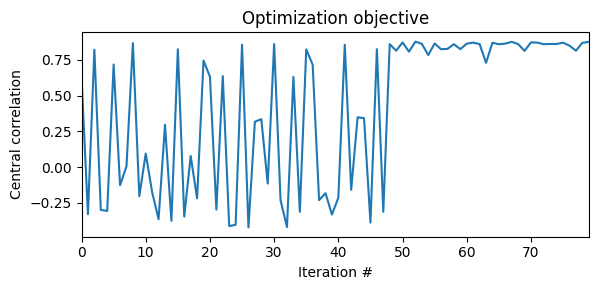

In [13]:
outputs.plot_optimization_objective();

### Visualize results

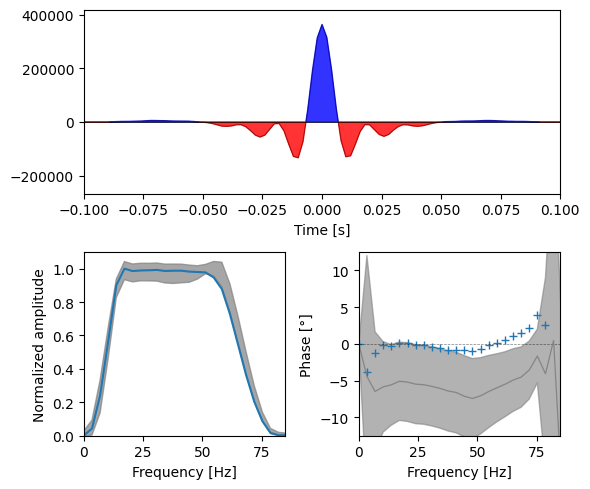

In [14]:
fig, axes = outputs.plot_wavelet(fmax=85, phi_max=15, figsize=(6,5))
axes[0].set_xlim((-0.1,0.1))
axes[2].set_ylim((-12.5,12.5))
fig.tight_layout()

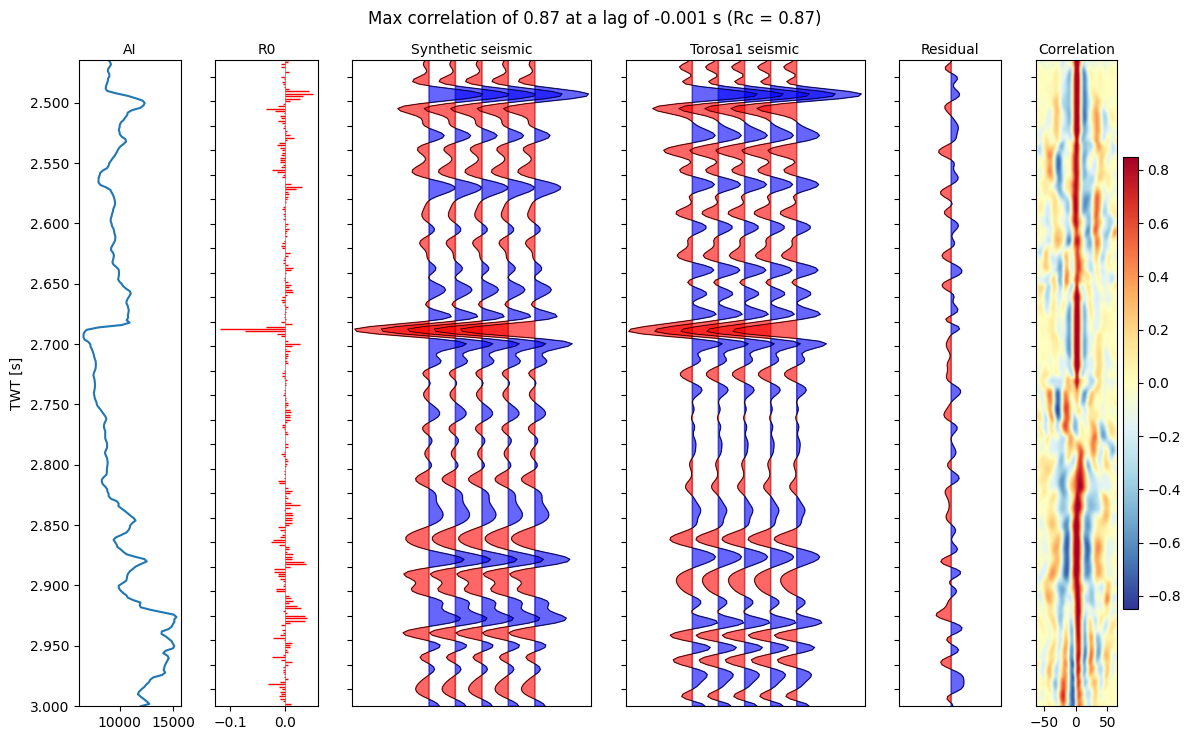

In [15]:
_scale = 120000
fig, axes = outputs.plot_tie_window(wiggle_scale=_scale, figsize=(12.,7.5))

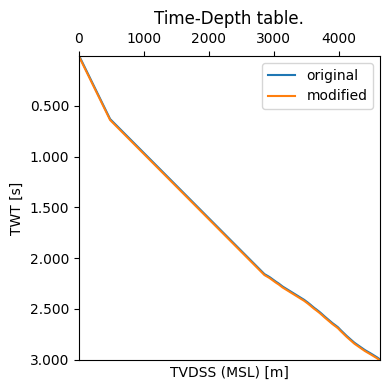

In [16]:
fig,ax = viz.plot_td_table(inputs.table, plot_params=dict(label='original'))
viz.plot_td_table(outputs.table,  plot_params=dict(label='modified'), fig_axes=(fig,ax))
ax.legend(loc='best')

#### Test automatic Stretch & Squeeze

In [17]:
s_and_s_params = dict(window_length=0.060, max_lag=0.010) # in seconds

outputs2 = autotie.stretch_and_squeeze(inputs,
                                       outputs,
                                       wavelet_extractor,
                                       modeler,
                                       wavelet_scaling_params,
                                       best_parameters,
                                       s_and_s_params)

upper
[3521.67660784 3578.34915978 3605.12440624 3558.34060283 3508.91240132
 3518.8678155  3565.31077779 3556.8558526  3511.38124881 3507.09247506
 3482.88957567 3457.15602471 3445.89942712 3500.2529086  3812.35226807
 4195.23612086 4436.8366873  4653.14856321 4724.12606322 4693.08268278
 4601.50360308 4325.22709642 4184.46839691 4162.11056054 4090.75007987
 4046.38214518 3958.32425052 3914.45615092 3909.36417627 3886.23044369
 3907.96154239 3926.11478661 3996.98503643 4110.32348555 4122.20615148
 4040.0507734  3941.51530915 3878.03671935 3829.78519884 3775.12804983
 3707.65308302 3616.87060673 3565.2142678  3551.76587699 3521.99025785
 3462.33056969 3360.52873345 3282.27614211 3250.88932648 3227.97304336
 3223.55887505 3286.9099521  3435.70947181 3536.76985722 3570.57076823
 3609.19579184 3643.6972092  3671.13550068 3686.50534088 3691.90007122
 3665.30199305 3634.95372024 3616.28153608 3593.54721071 3579.87138483
 3558.48231139 3538.19718793 3546.76112224 3569.80449056 3586.09800597


100%|██████████| 60/60 [00:10<00:00,  5.84it/s]


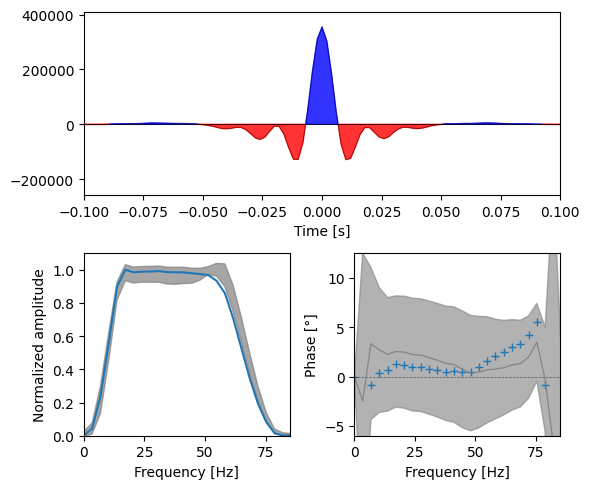

In [18]:
fig, axes = outputs2.plot_wavelet(fmax=85, phi_max=25, figsize=(6,5))
axes[0].set_xlim((-0.1,0.1))
axes[2].set_ylim((-6.,12.5))
fig.tight_layout()

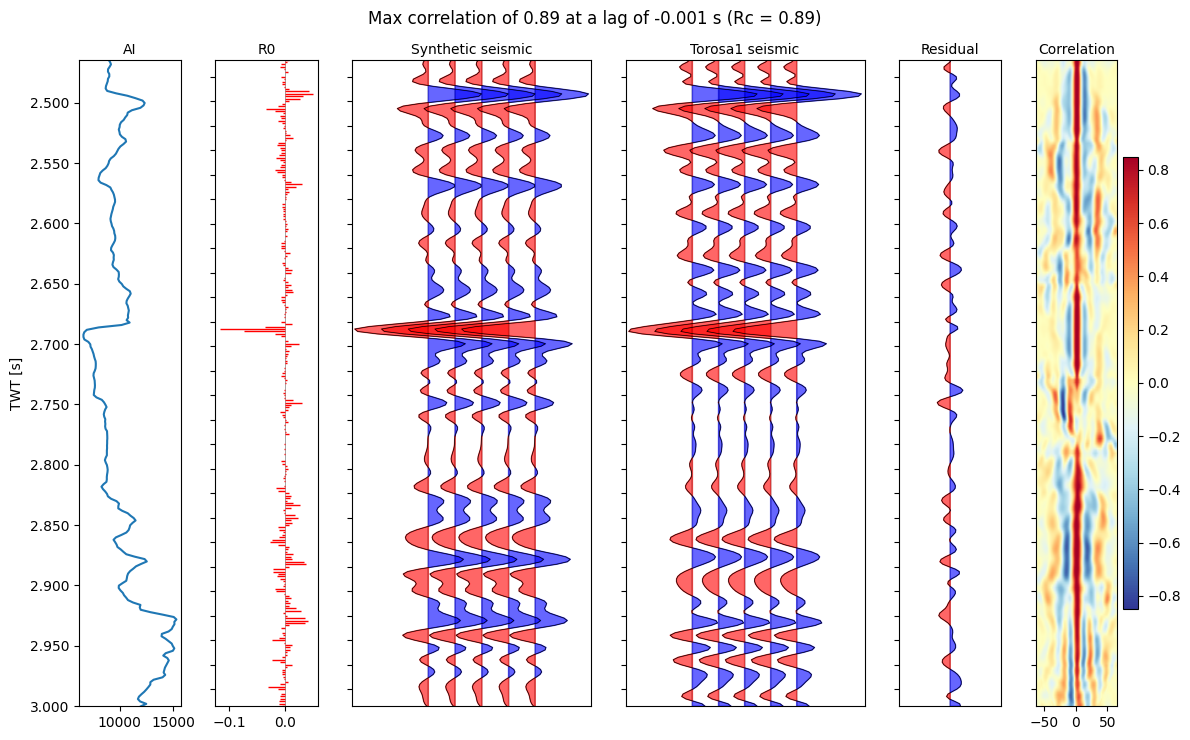

In [19]:
fig, axes = outputs2.plot_tie_window(wiggle_scale=_scale, figsize=(12.,7.5));
from matplotlib.ticker import MaxNLocator
axes[0].xaxis.set_major_locator(MaxNLocator(nbins=2))

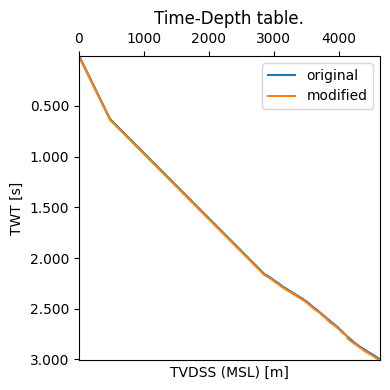

In [20]:
fig,ax = viz.plot_td_table(inputs.table, plot_params=dict(label='original'))
viz.plot_td_table(outputs2.table,  plot_params=dict(label='modified'), fig_axes=(fig,ax))
ax.legend(loc='best')

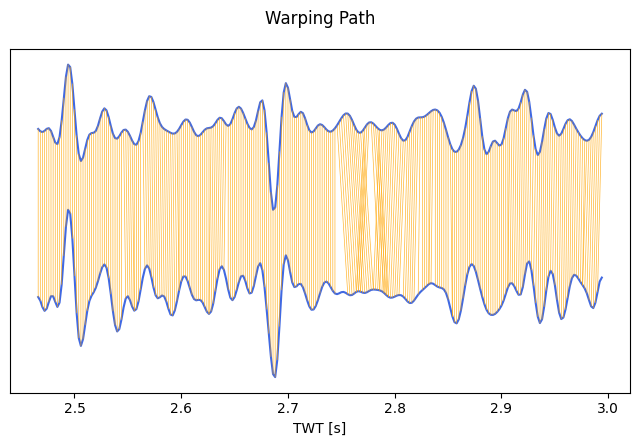

In [21]:
fig, ax = viz.plot_warping(outputs.synth_seismic, outputs.seismic, outputs2.dlags)